In [3]:
from tqdm import tqdm

In [2]:
import numpy as np
import pandas as pd
from together import Together

emphasis_task = pd.read_csv('Hyperbaton examples - Emphasis Identification Task.csv')
print(emphasis_task.iloc[69])
emphasis_task = emphasis_task.drop(index=69)
print(emphasis_task.iloc[69])

Ground Truth Backtranslations                                                  NaN
Example:                         ABOVE THIS ROW ARE EXAMPLES FROM THE INTERNET,...
Source:                                                                        NaN
Emphasis (Normal)                                                              NaN
Emphasis (Hyperbaton)                                                          NaN
Name: 69, dtype: object
Ground Truth Backtranslations      "There was no light in the room."
Example:                         "Light there was none in the room."
Source:                                                          LLM
Emphasis (Normal)                                         There, the
Emphasis (Hyperbaton)                                     Light, the
Name: 70, dtype: object


In [ ]:
client = Together(api_key="apikey")

response = client.chat.completions.create(
    model="meta-llama/Llama-3.3-70B-Instruct-Turbo",
    messages=[{"role": "user", "content": "What are the top 3 things to do in New York?"}],
    stream=False
)

In [ ]:
from openai import OpenAI
client_openai = OpenAI(api_key="apikey")
def get_model_response_openai(model, prompt):
    completion = client_openai.chat.completions.create(
        model=model,
        messages=[
            {"role": "user", "content": prompt}
        ]
    )
    return completion.choices[0].message.content


In [63]:
def get_model_response(model, prompt):
    if model in ["gpt-3.5-turbo-0125", "gpt-4o-mini"]:
        completion = client_openai.chat.completions.create(
            model=model,
            messages=[
                {"role": "user", "content": prompt}
            ]
        )
        return completion.choices[0].message.content
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        stream=False
    )
    return response.choices[0].message.content

In [7]:
emphasis_task

,Ground Truth Backtranslations,Example:,Source:,Emphasis (Normal),Emphasis (Hyperbaton)
0,There was no object. There was no passion. I l...,"""Object there was none. Passion there was none...",ThoughtCo,"object, passion","Object, passion"
1,"A butterfly emerged from a cocoon, like a lady...","""From Cocoon forth a Butterfly\nAs Lady from h...",ThoughtCo,"butterfly, emerged","From, Lady"
2,"Some rise by sin, and some fall by virtue","""Some rise by sin, and some by virtue fall.""",ThoughtCo,"Some, rise","Some, rise"
3,And a small cabin made of clay and wattles was...,"""And a small cabin build there, of clay and wa...",ThoughtCo,"small, cabin","And, small"
4,Mankind do not pity this busy monster,"""pity this busy monster mankind not""",ThoughtCo,"Mankind, do","pity, busy"
...,...,...,...,...,...
2579,"""The snow fell gently from the sky, covering t...","""Gently fell the snow from the sky, covering t...",LLM,"The, white","Gently, white"
2580,"""The distant mountains rose above the valley, ...","""Above the valley rose the distant mountains, ...",LLM,"The, with","Above, with"
2581,"""The clouds parted, revealing a brilliant blue...","""Parted were the clouds, revealing a brilliant...",LLM,"The, blue","Parted, blue"
2582,"""The world seemed still, the air heavy with th...","""Seemed still was the world, the air heavy wit...",LLM,"The, of","Seemed, of"


In [26]:
#for each model
#generate emphasis words for ground truth backtranslations and example column
#log them into df {model_name}+{normal or hyperbaton}+{prediction}
#precision, recall, f1

In [59]:
def get_emphasis_words(model, sentence):
    prompt = f"Output the word or words you think that are the emphasis in the following sentence. {sentence} If there is more than one word, separate them with commas. Only output your best guess at emphasis words. I cannot emphasize enough: do not include an explanation or anything additional than the emphasis words. For example, if you have a sentence like 'I am the president', and you believe the emphasis words to be 'I' and 'president', simply return 'I, president'- nothing else. This is absolutely crucial."
    return get_model_response(model, prompt)

In [9]:
def calculate_metrics(ground_truth, predictions):
    true_positives = set(ground_truth) & set(predictions) 
    false_positives = set(predictions) - set(ground_truth)
    false_negatives = set(ground_truth) - set(predictions) 

    precision = len(true_positives) / (len(true_positives) + len(false_positives)) if len(predictions) > 0 else 0
    recall = len(true_positives) / (len(true_positives) + len(false_negatives)) if len(ground_truth) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score


In [10]:
def get_words(input_string):
    return [word.strip().lower() for word in input_string.split(",")]

In [ ]:
import ray
import time
@ray.remote
def process_row(row, model = "mistralai/Mixtral-8x7B-Instruct-v0.1"):
    from openai import OpenAI
    client_openai = OpenAI(api_key="apikey")
    def get_model_response(model, prompt):
        if model in ["gpt-3.5-turbo-0125", "gpt-4o-mini"]:
            completion = client_openai.chat.completions.create(
                model=model,
                messages=[
                    {"role": "user", "content": prompt}
                ]
            )
            return completion.choices[0].message.content
        response = client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": prompt}],
            stream=False
        )
        return response.choices[0].message.content
    def get_emphasis_words(model, sentence):
        prompt = f"Output the word or words you think that are the emphasis in the following sentence. {sentence} If there is more than one word, separate them with commas. Only output your best guess at emphasis words. I cannot emphasize enough: do not include an explanation or anything additional than the emphasis words. For example, if you have a sentence like 'I am the president', and you believe the emphasis words to be 'I' and 'president', simply return 'I, president'- nothing else. This is absolutely crucial."
        return get_model_response(model, prompt)
    
    def calculate_metrics(ground_truth, predictions):
        true_positives = set(ground_truth) & set(predictions) 
        false_positives = set(predictions) - set(ground_truth)
        false_negatives = set(ground_truth) - set(predictions) 

        precision = len(true_positives) / (len(true_positives) + len(false_positives)) if len(predictions) > 0 else 0
        recall = len(true_positives) / (len(true_positives) + len(false_negatives)) if len(ground_truth) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        return precision, recall, f1_score

    def get_words(input_string):
        return [word.strip().lower() for word in input_string.split(",")]
    normal_emphasis_words = get_emphasis_words(model, row["Ground Truth Backtranslations"])
    hyperbaton_emphasis_words = get_emphasis_words(model, row["Example:"])
    normal_metrics = calculate_metrics(get_words(row["Emphasis (Normal)"]), get_words(normal_emphasis_words))
    hyperbaton_metrics = calculate_metrics(get_words(row["Example:"]), get_words(hyperbaton_emphasis_words))
    time.sleep(2)
    return normal_emphasis_words, hyperbaton_emphasis_words, normal_metrics, hyperbaton_metrics

In [29]:
import json

In [72]:
models = ["mistralai/Mixtral-8x7B-Instruct-v0.1",
          "meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo",
          "meta-llama/Llama-3.3-70B-Instruct-Turbo",
          "gpt-4o-mini",
          "gpt-3.5-turbo-0125"
          ]

In [ ]:
ray.shutdown()
ray.init()
# Submit tasks to Ray
for model in models:
    futures = [process_row.remote(row, model) for _, row in emphasis_task.iterrows()]

    # Collect results with a progress bar
    results = []
    for result in tqdm(ray.get(futures)):
        results.append(result)
    normal_emphasis_words = [res[0] for res in results]
    hyperbaton_emphasis_words = [res[1] for res in results]
    normal_metrics = [res[2] for res in results]
    hyperbaton_metrics = [res[3] for res in results]
    outputs = {
        "normal_emphasis_words": normal_emphasis_words,
        "hyperbaton_emphasis_words": hyperbaton_emphasis_words,
        "normal_metrics": normal_metrics,
        "hyperbaton_metrics": hyperbaton_metrics
    }
    file_path = f"{model.split('/')[-1]}_outputs.json"

    # Writing to the JSON file
    with open(file_path, "w") as json_file:
        json.dump(outputs, json_file, indent=4)

2024-12-11 10:16:14,279	INFO worker.py:1812 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 
100%|██████████| 2583/2583 [00:00<?, ?it/s]


In [20]:
ray.shutdown()

In [95]:
model_metrics = pd.DataFrame(columns=["Model", "Normal Sentence Precision", "Normal Sentence Recall", "Normal Sentence F1 Score", "Hyperbaton Sentence Precision", "Hyperbaton Sentence Recall", "Hyperbaton Sentence F1 Score"])
for model in models:
    file_path = f"{model.split('/')[-1]}_outputs.json"
    with open(file_path, "r") as json_file:
        data = json.load(json_file)
    normal_precision, normal_recall, normal_f1_score = zip(*data['normal_metrics'])
    hyperbaton_precision, hyperbaton_recall, hyperbaton_f1_score = zip(*data['hyperbaton_metrics'])
    model_metrics = pd.concat([model_metrics, pd.DataFrame([{"Model": model.split('/')[-1], "Normal Sentence Precision": np.average(normal_precision), "Normal Sentence Recall": np.average(normal_recall), "Normal Sentence F1 Score": np.average(normal_f1_score), "Hyperbaton Sentence Precision": np.average(hyperbaton_precision), "Hyperbaton Sentence Recall": np.average(hyperbaton_recall), "Hyperbaton Sentence F1 Score": np.average(hyperbaton_f1_score)}])], ignore_index=True)


C:\Users\khelt\AppData\Local\Temp\ipykernel_30804\1507501376.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_metrics = pd.concat([model_metrics, pd.DataFrame([{"Model": model.split('/')[-1], "Normal Sentence Precision": np.average(normal_precision), "Normal Sentence Recall": np.average(normal_recall), "Normal Sentence F1 Score": np.average(normal_f1_score), "Hyperbaton Sentence Precision": np.average(hyperbaton_precision), "Hyperbaton Sentence Recall": np.average(hyperbaton_recall), "Hyperbaton Sentence F1 Score": np.average(hyperbaton_f1_score)}])], ignore_index=True)


In [99]:
model_metrics

,Model,Normal Sentence Precision,Normal Sentence Recall,Normal Sentence F1 Score,Hyperbaton Sentence Precision,Hyperbaton Sentence Recall,Hyperbaton Sentence F1 Score
0,Mixtral-8x7B-Instruct-v0.1,0.020108,0.023745,0.021134,0.013104,0.011227,0.011070
1,Meta-Llama-3.1-8B-Instruct-Turbo,0.145003,0.162021,0.150430,0.010517,0.006420,0.007771
2,Llama-3.3-70B-Instruct-Turbo,0.074199,0.097884,0.082797,0.003207,0.003388,0.003281
3,gpt-4o-mini,0.074519,0.120338,0.089231,0.002917,0.003258,0.003037
4,gpt-3.5-turbo-0125,0.071700,0.106207,0.082407,0.002452,0.002936,0.002630


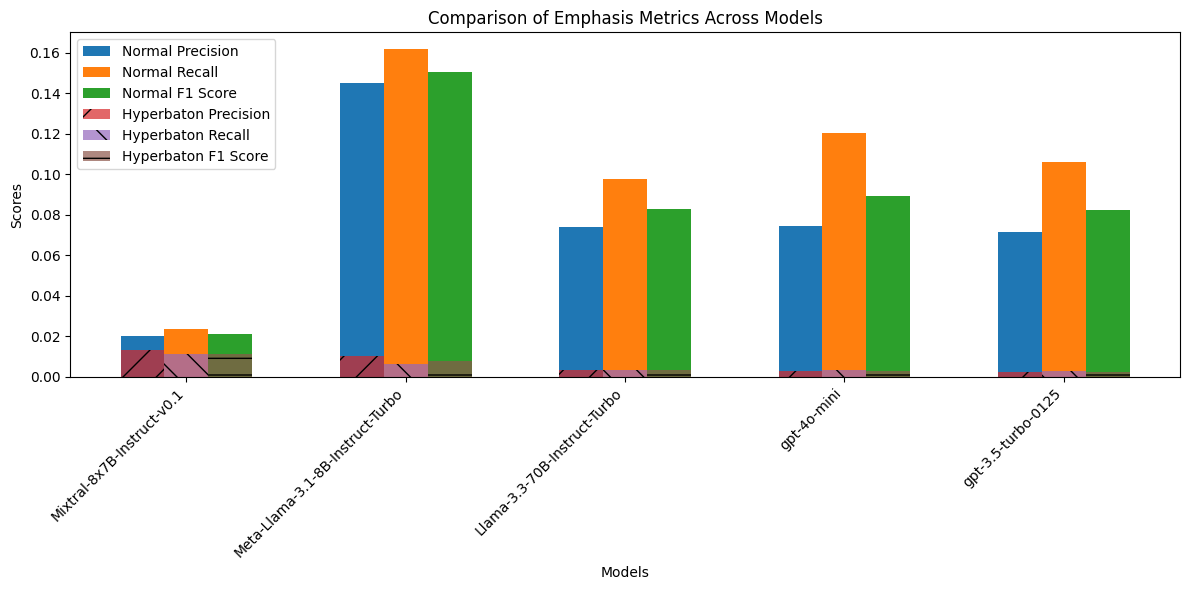

In [97]:
import matplotlib.pyplot as plt
df = model_metrics

# Grouped bar chart
metrics = ["Precision", "Recall", "F1 Score"]
x_labels = df["Model"]
x = np.arange(len(x_labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Plot each metric for Normal Sentence
ax.bar(x - width, df["Normal Sentence Precision"], width, label="Normal Precision")
ax.bar(x, df["Normal Sentence Recall"], width, label="Normal Recall")
ax.bar(x + width, df["Normal Sentence F1 Score"], width, label="Normal F1 Score")

# Plot each metric for Hyperbaton Sentence
ax.bar(x - width, df["Hyperbaton Sentence Precision"], width, label="Hyperbaton Precision", alpha=0.7, hatch='/')
ax.bar(x, df["Hyperbaton Sentence Recall"], width, label="Hyperbaton Recall", alpha=0.7, hatch='\\')
ax.bar(x + width, df["Hyperbaton Sentence F1 Score"], width, label="Hyperbaton F1 Score", alpha=0.7, hatch='-')

# Add labels and title
ax.set_ylabel("Scores")
ax.set_xlabel("Models")
ax.set_title("Comparison of Emphasis Metrics Across Models")
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=45, ha="right")
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [77]:
file_paths = [f"{model.split('/')[-1]}_outputs.json" for model in models]

In [78]:
with open(file_paths[0], "r") as json_file:
    data = json.load(json_file)

In [84]:
data.keys()

dict_keys(['normal_emphasis_words', 'hyperbaton_emphasis_words', 'normal_metrics', 'hyperbaton_metrics'])

In [82]:
precision, recall, f1_score = zip(*data['normal_metrics'])

In [83]:
f1_score

(0,
 0.4,
 0,
 0,
 0,
 0.4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.8,
 0,
 0,
 0,
 0.5,
 0,
 0,
 0.5,
 0,
 0,
 0,
 0,
 0,
 0.5,
 0,
 0,
 0,
 0,
 0,
 0.5,
 0,
 0.5,
 0,
 0,
 0.4,
 0,
 0.4,
 0,
 0,
 0,
 0.5,
 0,
 0,
 0,
 0,
 0,
 0.5,
 0,
 0,
 0,
 0.8,
 0,
 0,
 0,
 0,
 1.0,
 0,
 0,
 0.5,
 0.5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.5,
 0,
 0,
 0,
 0,
 0,
 0,
 0.5,
 0,
 0,
 0,
 0,
 0.5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.5,
 0.4,
 0.6666666666666666,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.3333333333333333,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.5,
 0.5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.4,
 0,
 0,
 0,
 0,
 0,


In [23]:
mistral_7b_normal_emphasis_words = [res[0] for res in results]
mistral_7b_hyperbaton_emphasis_words = [res[1] for res in results]
mistral_7b_normal_metrics = [res[2] for res in results]
mistral_7b_hyperbaton_metrics = [res[3] for res in results]

In [25]:
import json
mistral_outputs = {
    "mistral_7b_normal_emphasis_words": mistral_7b_normal_emphasis_words,
    "mistral_7b_hyperbaton_emphasis_words": mistral_7b_hyperbaton_emphasis_words,
    "mistral_7b_normal_metrics": mistral_7b_normal_metrics,
    "mistral_7b_hyperbaton_metrics": mistral_7b_hyperbaton_metrics
}

file_path = "mistral_7b_outputs.json"

# Writing to the JSON file
with open(file_path, "w") as json_file:
    json.dump(mistral_outputs, json_file, indent=4)  # `indent=4` formats the JSON for better readability

In [49]:
llama_70b_normal_emphasis_words = []
llama_70b_hyperbaton_emphasis_words = []
llama_70b_normal_metrics = []
llama_70b_hyperbaton_metrics = []
for index, row in tqdm(emphasis_task.iterrows()):
    normal_emphasis_words = get_emphasis_words(model="meta-llama/Llama-3.3-70B-Instruct-Turbo", sentence=row["Ground Truth Backtranslations"])
    llama_70b_normal_emphasis_words.append(normal_emphasis_words)
    hyperbaton_emphasis_words = get_emphasis_words(model="meta-llama/Llama-3.3-70B-Instruct-Turbo", sentence=row["Example:"])
    llama_70b_hyperbaton_emphasis_words.append(hyperbaton_emphasis_words)
    llama_70b_normal_metrics.append(calculate_metrics(get_words(row["Emphasis (Normal)"]), get_words(normal_emphasis_words)))
    llama_70b_hyperbaton_metrics.append(calculate_metrics(get_words(row["Example:"]), get_words(hyperbaton_emphasis_words)))

2583it [2:03:03,  2.86s/it]


In [32]:
normal_emphasis_words = get_emphasis_words(model="meta-llama/Llama-3.3-70B-Instruct-Turbo", sentence=emphasis_task.iloc[0]["Ground Truth Backtranslations"])

In [50]:
llama_70b_normal_precision, llama_70b_normal_recall, llama_70b_normal_f1 = zip(*llama_70b_normal_metrics)

In [57]:
llama_70b_hyperbaton_precision, llama_70b_hyperbaton_recall, llama_70b_hyperbaton_f1 = zip(*llama_70b_hyperbaton_metrics)

In [58]:
np.average(llama_70b_normal_f1[0:70]), np.average(llama_70b_hyperbaton_f1[0:70])

(np.float64(0.20329004329004327), np.float64(0.011111111111111112))

In [ ]:
np.average(llama_70b_hyperbaton_f1[0:70]), np.average(llama[0:70])

In [59]:
np.average(llama_70b_normal_f1), np.average(llama_70b_hyperbaton_f1)

(np.float64(0.07691842935745374), np.float64(0.00404291798020021))

In [38]:
calculate_metrics(get_words(emphasis_task.iloc[0]["Emphasis (Normal)"]), get_words(normal_emphasis_words))

(0.6666666666666666, 1.0, 0.8)

In [63]:
import json
llama_outputs = {
    "llama_70b_normal_emphasis_words": llama_70b_normal_emphasis_words,
    "llama_70b_hyperbaton_emphasis_words": llama_70b_hyperbaton_emphasis_words,
    "llama_70b_normal_metrics": llama_70b_normal_metrics,
    "llama_70b_hyperbaton_metrics": llama_70b_hyperbaton_metrics
}

In [64]:
file_path = "llama_outputs.json"

# Writing to the JSON file
with open(file_path, "w") as json_file:
    json.dump(llama_outputs, json_file, indent=4)  # `indent=4` formats the JSON for better readability